<a href="https://colab.research.google.com/github/ZhenyaTumarkin/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [18]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [19]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [20]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [21]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [22]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

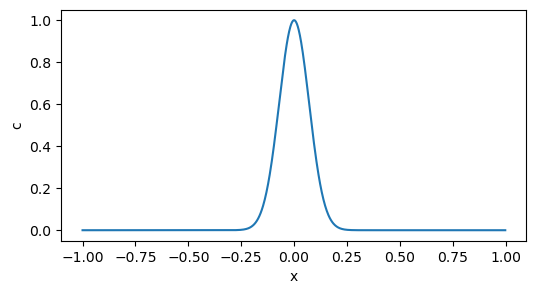

In [23]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

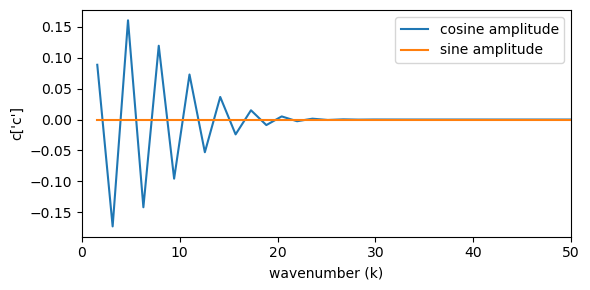

In [24]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [25]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [26]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

2024-10-29 14:18:34,588 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [27]:
solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [28]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

2024-10-29 14:18:35,240 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

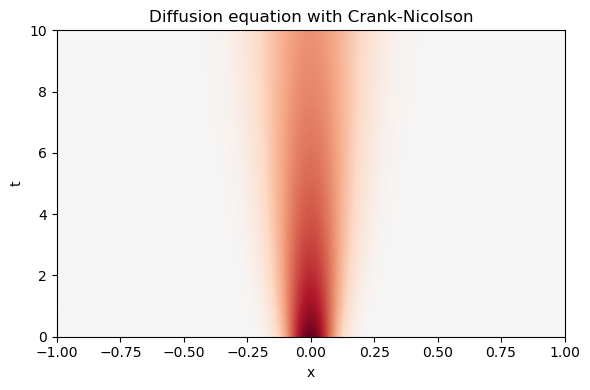

In [29]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [30]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

2024-10-29 14:18:36,610 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2024-10-29 14:18:36,634 solvers 0/1 INFO :: Simulation stop time reached.


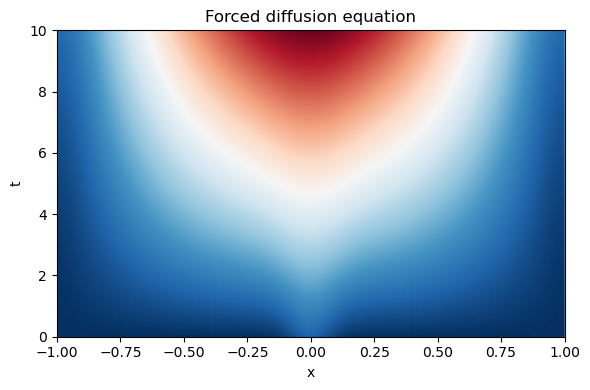

In [31]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx/2; x_end=Lx/2 # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

In [32]:
def compute (tstop):
  Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
  Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
  x_start=-Lx; x_end=Lx # The starting and ending bounds on x
  kappa = 0.001 # set the diffusivity

  # Create an x-coordinate, a corresponding basis, and a distributor
  xcoord = dedalus.Coordinate('x')
  dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
  x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
  x = dist.local_grid(x_basis)

  # Set initial conditions
  c = dist.Field(name='c', bases=x_basis)
  w = 0.1 # Set the width of the initial Gaussian
  c.change_scales(1) # Set values on regular grid
  c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

  # Operators
  dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

  # Create an operator that applies a function to the variable on a grid
  f_x = dist.Field(bases=x_basis)
  f_x['g'] = np.cos(np.pi * x / Lx)

  # Specify the problem
  problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
  problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

  timestepper = dedalus.CNAB1
  solver = problem.build_solver(timestepper)

  solver.stop_sim_time =tstop # Stop at 10 simulation time units

  # Main loop
  timestep = 0.1
  c.change_scales(1)
  c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
  while solver.proceed:
      solver.step(timestep)
      if solver.iteration % 10000 == 0: # Every 10000 timesteps, print a message to the screen with the progress
          logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
      c.change_scales(1)
      c_save.append(np.copy(c['g']))
      t_save.append(solver.sim_time)
  return c_save,t_save

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

In [33]:
def analytical():

  kappa = 0.001
  Lx=2
  Nx = 1024
  x = np.linspace(-Lx,Lx,Nx)

  c = 1/kappa*Lx**2/(np.pi**2)*np.cos(np.pi*x/2)
  return c

def rmse(model,analytical):
  sq_diff = sum((model-analytical)**2)
  avg = sq_diff/len(model)
  return np.sqrt(avg)
sol = analytical()


In [34]:
c1,t1 = compute(20000)

2024-10-29 14:18:37,755 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2024-10-29 14:18:39,729 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01
2024-10-29 14:18:41,408 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01
2024-10-29 14:18:43,340 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01
2024-10-29 14:18:45,315 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01
2024-10-29 14:18:47,272 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01
2024-10-29 14:18:49,221 __main__ 0/1 INFO :: Iteration=60000, Time=6.000000e+03, dt=1.000000e-01
2024-10-29 14:18:51,200 __main__ 0/1 INFO :: Iteration=70000, Time=7.000000e+03, dt=1.000000e-01
2024-10-29 14:18:52,978 __main__ 0/1 INFO :: Iteration=80000, Time=8.000000e+03, dt=1.000000e-01
2024-10-29 14:18:54,628 __main__ 0/1 INFO :: Iteration=90000, Time=9.000000e+03, dt=1.000000

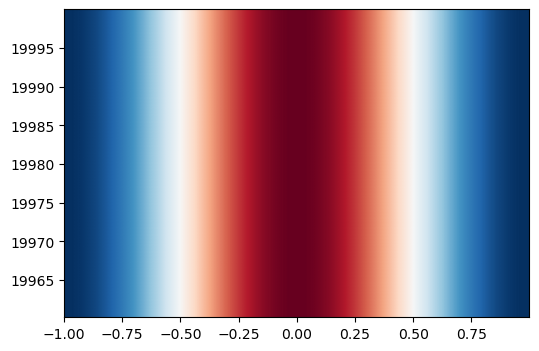

In [35]:
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t1[-400:-1]), np.array(c1[-400:-1]), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))

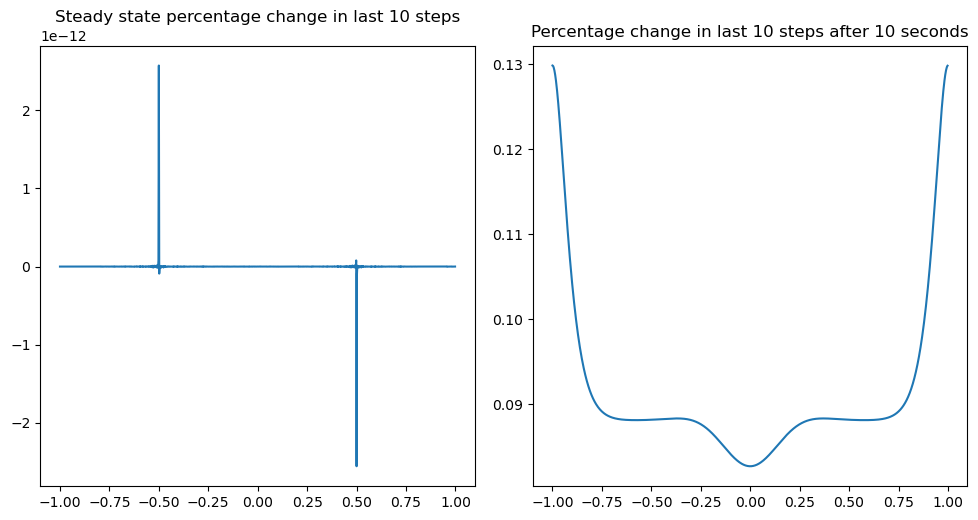

In [36]:
fig , ax = plt.subplots(1,2,figsize=(10,5))
fig.tight_layout()
ax[1].plot(x,(c_save[-1]-c_save[-10])/c_save[-1])
ax[0].plot(x,(c1[-1]-c1[-10])/c1[-1])
ax[0].set_title('Steady state percentage change in last 10 steps')
ax[1].set_title('Percentage change in last 10 steps after 10 seconds')
plt.show()

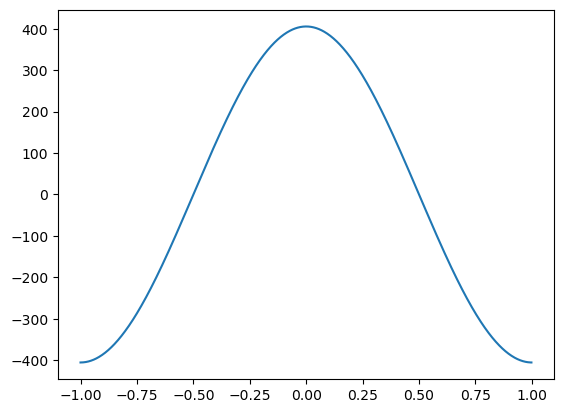

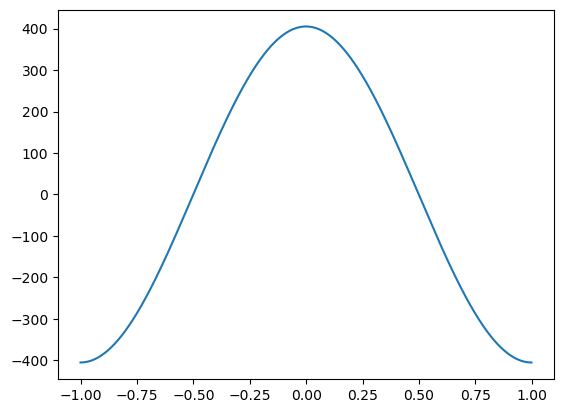

In [37]:
plt.plot(x,c1[200000])
plt.show()
plt.plot(x,sol)

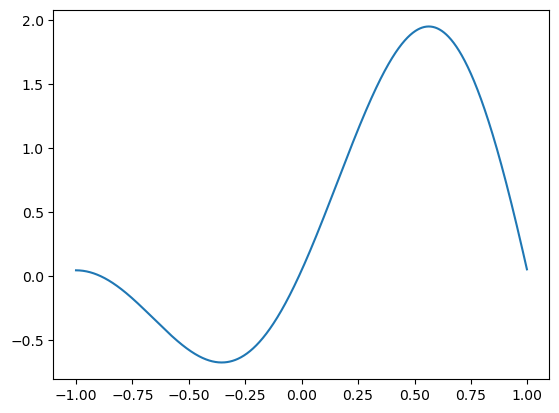

In [38]:
plt.plot(x,c1[-1]-sol)

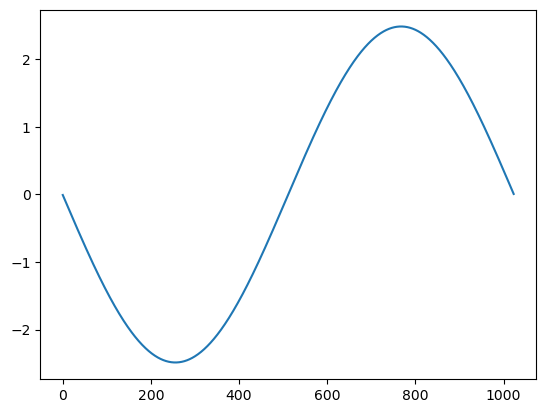

In [48]:
#plt.plot(c1[-1][0:511])
#plt.plot(c1[-1][512:][::-1])
plt.plot(c1[-1]-c1[-1][::-1])
       

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

### 5.2 Variable difusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

In [49]:
def variable(K0, scalex):
  # Write a Dedalus script to solve the diffusion equation with a spatially-variable diffusivity
  # It is fine to copy and paste the scripts above as a starting point.
  Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
  Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
  x_start=-Lx; x_end=Lx # The starting and ending bounds on x
  

  # Create an x-coordinate, a corresponding basis, and a distributor
  xcoord = dedalus.Coordinate('x')
  dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
  x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
  x = dist.local_grid(x_basis)

  # Set initial conditions
  c = dist.Field(name='c', bases=x_basis)
  w = 0.1 # Set the width of the initial Gaussian
  c.change_scales(1) # Set values on regular grid
  c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

  # Operators
  dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator



  #create kappa func
  K_x = dist.Field( bases=x_basis)
  K_x['g'] = K0*(0.1+np.tanh(x/scalex)+1)/2

  # Specify the problem
  problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
  problem.add_equation("dt(c) - dx(K_x * dx(c)) = 0"); # Write out the equation to be solved

  timestepper = dedalus.CNAB1
  solver = problem.build_solver(timestepper)

  solver.stop_sim_time = 10
  # Stop at 10 simulation time units

  # Main loop
  timestep = 0.1
  c.change_scales(1)
  c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
  while solver.proceed:
      solver.step(timestep)
      if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
          logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
      c.change_scales(1)
      c_save.append(np.copy(c['g']))
      t_save.append(solver.sim_time)
  return c_save

2024-10-29 14:25:23,428 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s
2024-10-29 14:25:23,510 solvers 0/1 INFO :: Simulation stop time reached.
2024-10-29 14:25:23,980 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2024-10-29 14:25:24,274 solvers 0/1 INFO :: Simulation stop time reached.


Text(0.5, 1.0, 'K=0.001')

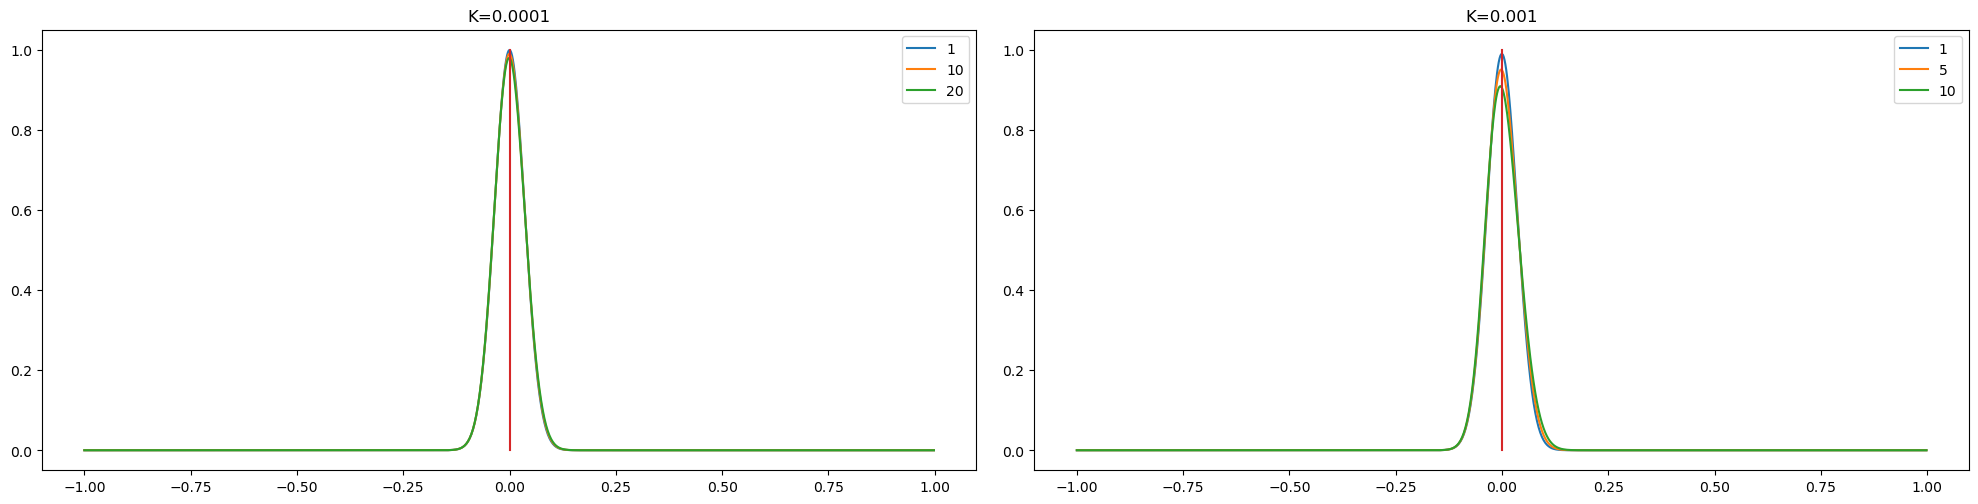

In [50]:
fig, ax = plt.subplots(1,2,figsize = (20,5))
fig.tight_layout()
c_save1=variable(0.0001,0.1)
ax[0].plot(x,c_save1[1],label = '1')

ax[0].plot(x,c_save1[10],label = '10')
ax[0].plot(x,c_save1[20],label = '20')

c_save2=variable(0.001,0.1)
ax[1].plot(x,c_save2[1],label = '1')
ax[1].plot(x,c_save2[5],label = '5')
ax[1].plot(x,c_save2[10],label = '10')



ax[0].plot([0,0],[0,1])
ax[1].plot([0,0],[0,1])
ax[0].legend()
ax[1].legend()
ax[0].set_title('K=0.0001')
ax[1].set_title('K=0.001')

In [51]:
# Write a Dedalus script to solve the diffusion equation with a spatially-variable diffusivity
# It is fine to copy and paste the scripts above as a starting point.

2024-10-29 14:25:25,010 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2024-10-29 14:25:25,282 solvers 0/1 INFO :: Simulation stop time reached.


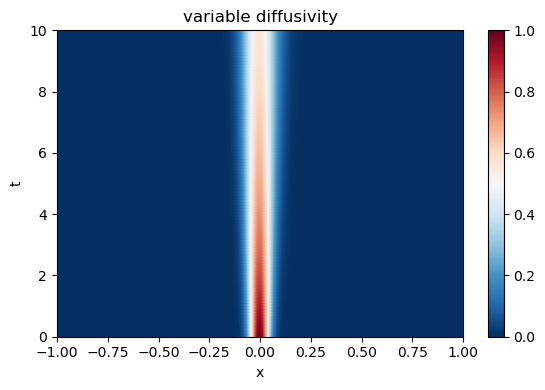

In [52]:
c_save=variable(0.001,1)
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('variable diffusivity')
plt.tight_layout()
plt.colorbar()

2024-10-29 14:25:26,749 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2024-10-29 14:25:27,026 solvers 0/1 INFO :: Simulation stop time reached.
2024-10-29 14:25:27,455 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2024-10-29 14:25:27,741 solvers 0/1 INFO :: Simulation stop time reached.


Text(0.5, 1.0, '1/x_coeff=1')

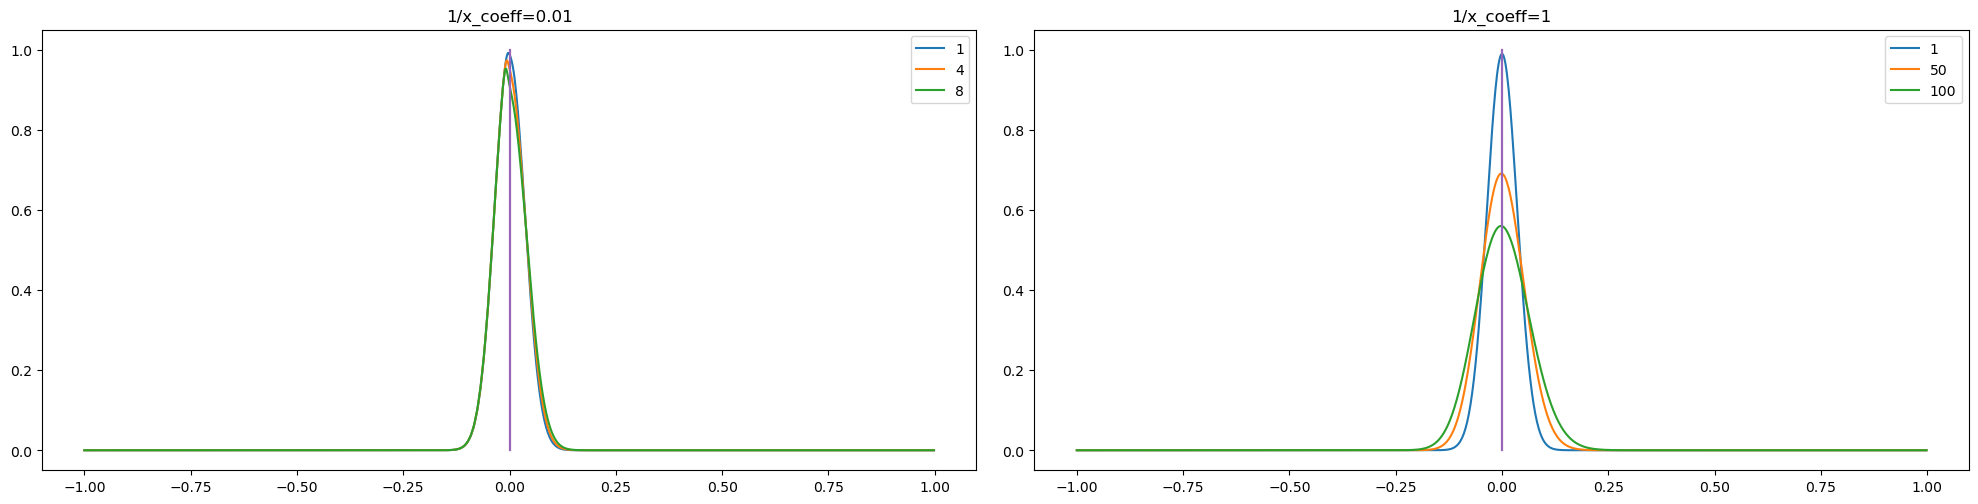

In [53]:
fig, ax = plt.subplots(1,2,figsize = (20,5))
fig.tight_layout()
c_save1=variable(0.001,0.01)
ax[0].plot(x,c_save1[1],label = '1')

ax[0].plot(x,c_save1[4],label = '4')
ax[0].plot(x,c_save1[8],label = '8')
ax[0].plot([0,0],[0,1])


c_save2=variable(0.001,1)
ax[1].plot(x,c_save2[1],label = '1')

ax[1].plot(x,c_save2[50],label = '50')
ax[1].plot(x,c_save2[100],label = '100')
ax[1].plot([0,0],[0,1])


ax[0].plot([0,0],[0,1])
ax[1].plot([0,0],[0,1])
ax[0].legend()
ax[1].legend()
ax[0].set_title('1/x_coeff=0.01')
ax[1].set_title('1/x_coeff=1')


Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

Decreasing the starting diffusivity reduces the assymetry caused by the spatially variable diffusivity. It similarly makes the solver destabilize at a later time.

Another significant parameter is the 1/x_coefficent. A large coefficent, makes tanh(x) insignificant, hence a constant diffusivity across all x, hence creating a symmetrical C(,x,t). In contrast The small coefficent makes a much more assymmetrical pattern, which becomes unstable very quickly at the current timestep =0.1 s.

Hence a parameter important in the observation of the real pattern, is the timestep. A smaller timestep simulation stays stable for a longer time.

INSERT COMMENTS HERE

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
